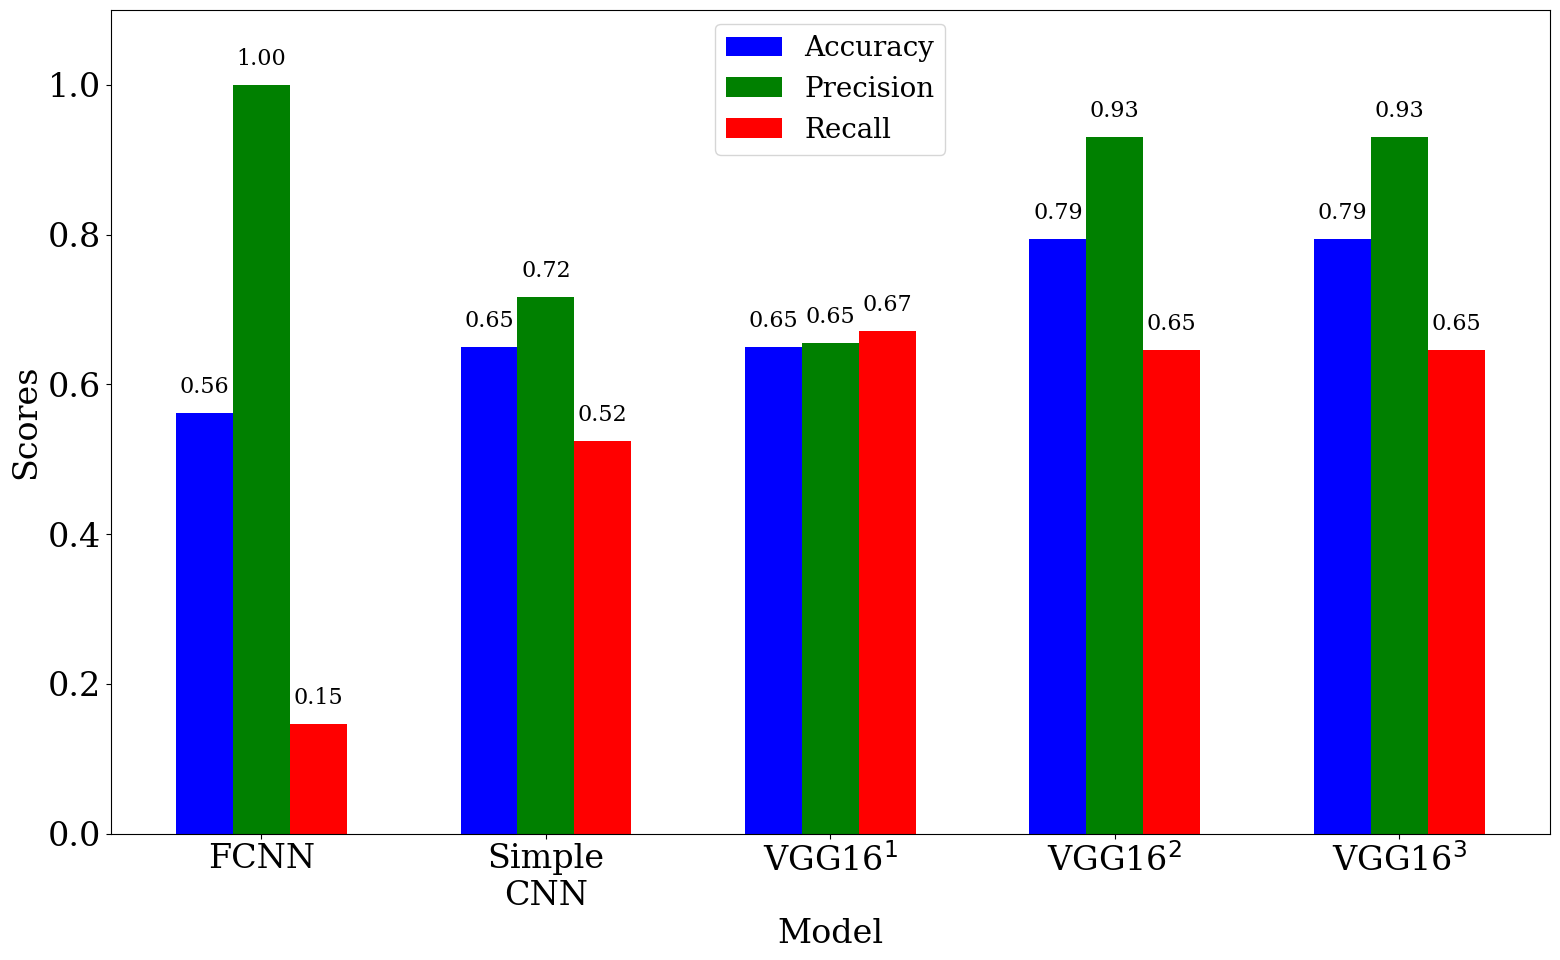

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


mpl.rcParams['font.size'] = 24
mpl.rcParams['font.family'] = 'serif'

# Data
models = ['FCNN', 'Simple\nCNN', 'VGG16$^1$', 'VGG16$^2$', 'VGG16$^3$']
parameters = [50.81, 10.51, 23.13, 23.13, 23.13]  # No. of parameters in millions
accuracy = [0.5625, 0.65, 0.65, 0.7937, 0.7937]
precision = [1.0, 0.7167, 0.6548, 0.9298, 0.9298]
recall = [0.1463, 0.5244, 0.6707, 0.6463, 0.6463]

# Plot
bar_width = 0.2
index = np.arange(len(models))
plt.figure(figsize=(16,10))
plt.bar(index - bar_width, accuracy, bar_width, color='b', label='Accuracy')
plt.bar(index, precision, bar_width, color='g', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='r', label='Recall')

mpl.rcParams['font.size'] = 16
for i in range(len(models)):
    plt.text(index[i] - bar_width, accuracy[i] + 0.02, f'{accuracy[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i], precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i] + bar_width, recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', va='bottom')

mpl.rcParams['font.size'] = 26
plt.xlabel('Model')
plt.ylim([0, 1.1])
plt.ylabel('Scores')
# plt.title('Model Performance Metrics')
plt.xticks(index, models)
mpl.rcParams['font.size'] = 20
plt.legend()
plt.tight_layout()
plt.show()


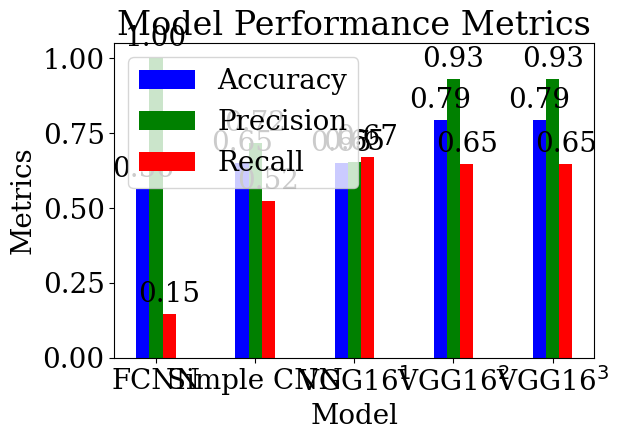

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['FCNN', 'Simple CNN', 'VGG16$^1$', 'VGG16$^2$', 'VGG16$^3$']
parameters = [50.81, 10.51, 23.13, 23.13, 23.13]  # No. of parameters in millions
accuracy = [0.5625, 0.65, 0.65, 0.7937, 0.7937]
precision = [1.0, 0.7167, 0.6548, 0.9298, 0.9298]
recall = [0.1463, 0.5244, 0.6707, 0.6463, 0.6463]

# Plot
bar_width = 0.2
index = np.arange(len(models)) * 1.5  # Adjust multiplier to increase gap width

plt.bar(index - bar_width, accuracy, bar_width, color='b', label='Accuracy')
plt.bar(index, precision, bar_width, color='g', label='Precision')
plt.bar(index + bar_width, recall, bar_width, color='r', label='Recall')

# Annotate values on top of bars
for i in range(len(models)):
    plt.text(index[i] - bar_width, accuracy[i] + 0.02, f'{accuracy[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i], precision[i] + 0.02, f'{precision[i]:.2f}', ha='center', va='bottom')
    plt.text(index[i] + bar_width, recall[i] + 0.02, f'{recall[i]:.2f}', ha='center', va='bottom')

plt.xlabel('Model')
plt.ylabel('Metrics')
plt.title('Model Performance Metrics')
plt.xticks(index, models)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true' 
# os.environ['CUDA_VISIBLE_DEVICES'] = '' 
# https://github.com/tensorflow/tensorflow/issues/53519
os.environ['TF_DEVICE_MIN_SYS_MEMORY_IN_MB'] = '256' 

import keras
import tensorflow as tf
from models import *
import matplotlib.pyplot as plt
import subprocess


In [4]:
def load_dataset(path='', subdirs=['train', 'val', 'test'], image_size=None, batch_size=None, label_mode=None):
    train_ds = keras.utils.image_dataset_from_directory(
        f'{path}/{subdirs[0]}',
        image_size=image_size,
        batch_size=batch_size,
        label_mode=label_mode,
        shuffle=True
    )

    val_ds = keras.utils.image_dataset_from_directory(
        f'{path}/{subdirs[1]}',
        image_size=image_size,
        batch_size=batch_size,
        label_mode=label_mode,
        shuffle=False
    )

    test_ds = keras.utils.image_dataset_from_directory(
        f'{path}/{subdirs[2]}',
        image_size=image_size,
        batch_size=batch_size,
        label_mode=label_mode,
        shuffle=False
    )

    # Used for plotting
    class_names = train_ds.class_names
    test_ds = test_ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
    return train_ds, val_ds, test_ds, class_names


In [5]:
dataset_base_path = '.'
db_name = 'dataset_256'

epochs = 50
image_size = (256, 256)
weights = 'imagenet'
lr_decay_factor = 0.1

# batch_size = 16
# init_lr = 1e-4
# model_name = f'simple_cnn'

subprocess.run(f'unzip -o -q {dataset_base_path}/{db_name}.zip', shell=True, capture_output=True, text=True)

batch_size = 32
train_ds, val_ds, test_ds, class_names = load_dataset(
    path=f'{dataset_base_path}/{db_name}', 
    subdirs=['train', 'valid', 'test'], 
    image_size=image_size, 
    batch_size=batch_size, 
    label_mode='int'
)

model_name = 'vgg16256'
bs = 16
lr = 1e-3

model = keras.models.load_model(f'./checkpoints/{model_name}_{bs}__{lr}__imagenet.keras')
# model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1),
    metrics=[
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.F1Score(name='f1score'),
    ]
)

preprocess = keras.applications.vgg16.preprocess_input
test_ds = test_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(lambda x, y: (x, tf.cast(y, tf.float32)))
# test_ds = test_ds.map(lambda x, y: (preprocess(x), y), num_parallel_calls=tf.data.AUTOTUNE)
# eval = model.evaluate(test_ds)
# print(eval)

Found 782 files belonging to 2 classes.
Found 106 files belonging to 2 classes.
Found 160 files belonging to 2 classes.


In [44]:
model_name = 'fcnnn256'
filename = f'{model_name}_{bs}__{lr}'
bs = 8
lr = 1e-3

def conf_mat(filename):
    model = keras.models.load_model(f'./best/best_checkpoints/{filename}.keras')
    # model.summary()

    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=1e-3),
        loss=keras.losses.BinaryCrossentropy(label_smoothing=0.1),
        metrics=[
            keras.metrics.BinaryAccuracy(name='accuracy'),
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.F1Score(name='f1score'),
        ]
    )

    labels = []
    for x, y in test_ds:
        labels.extend(y.numpy().tolist())
        
    fcnn_predictions = model.predict(test_ds)
    fcnn_predictions = (fcnn_predictions > 0.5).astype(np.uint8)
    fcnn_predictions = fcnn_predictions.reshape(160,).tolist()


    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    mpl.rcParams['font.family'] = 'serif'
    mpl.rcParams['font.size'] = '24'

    conf_matrix = confusion_matrix(labels, fcnn_predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Book', 'Notebook'])
    disp.plot(cmap='Blues', values_format='d')
    plt.savefig('conf_' + filename + '.png')
    plt.show()

5/5 [==============================] - 1s 101ms/step


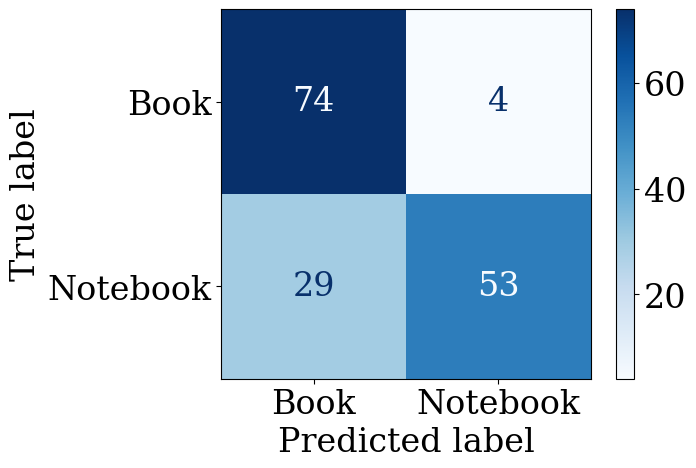

In [50]:
model_name = 'vgg16256'
bs = 16
lr = 1e-4
filename = f'{model_name}_{bs}__{lr}__None'
conf_mat(filename)
# print(labels)

In [27]:
fcnn_predictions = model.predict(test_ds)
fcnn_predictions = (fcnn_predictions > 0.5).astype(np.uint8)
fcnn_predictions = fcnn_predictions.reshape(160,).tolist()

5/5 [==============================] - 1s 96ms/step


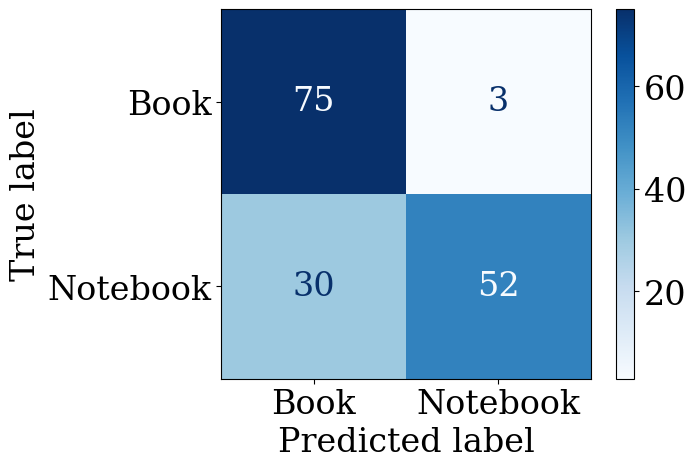

In [30]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.size'] = '24'

conf_matrix = confusion_matrix(labels, fcnn_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Book', 'Notebook'])
disp.plot(cmap='Blues', values_format='d')
plt.show()

In [75]:
import pandas as pd
import matplotlib
%matplotlib inline

In [106]:
history = pd.read_csv('./logs/vgg16256_16__0.0001__imagenet_fullTL.csv')

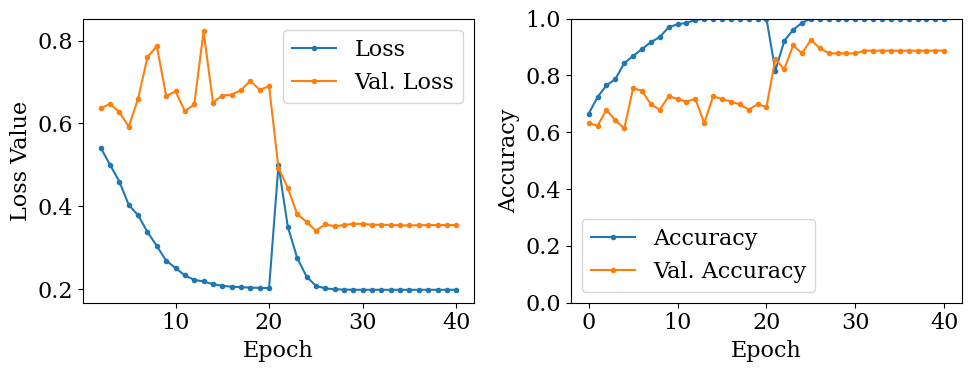

In [107]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.plot(history['loss'][2:], '.-')
plt.plot(history['val_loss'][2:], '.-')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(['Loss', 'Val. Loss'])

plt.subplot(1,2,2)
plt.plot(history['accuracy'], '.-')
plt.plot(history['val_accuracy'], '.-')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(['Accuracy', 'Val. Accuracy'])



# plt.subplot(1,3,3)
# plt.plot(history['lr'], '.-')
# # plt.plot(history['val_accuracy'], '.-')
# plt.xlabel('Epoch')
# plt.ylabel('Learning Rate')
# # plt.ylim([0, 1])
# # plt.legend(['accuracy', 'val_accuracy'])
plt.tight_layout()
plt.show()